In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,instruction,input,output,prompt
0,Create a function to calculate the sum of a se...,"[1, 2, 3, 4, 5]",# Python code\ndef sum_sequence(sequence):\n ...,Below is an instruction that describes a task....
1,Generate a Python code for crawling a website ...,website: www.example.com \ndata to crawl: phon...,import requests\nimport re\n\ndef crawl_websit...,Below is an instruction that describes a task....
2,Create a Python list comprehension to get the ...,NaN,"[x*x for x in [1, 2, 3, 5, 8, 13]]",Below is an instruction that describes a task....
3,Generate a python script to perform this action.,"Given a string, remove all the consecutive dup...",def remove_duplicates(string): \n result = ...,Below is an instruction that describes a task....
4,Write a python script to generates random numb...,NaN,def generate_random_divisible_number():\n i...,Below is an instruction that describes a task....


In [78]:
print(df['output'][0])

# Python code
def sum_sequence(sequence):
  sum = 0
  for num in sequence:
    sum += num
  return sum


In [80]:
with open('output.txt', 'w', encoding='utf-8') as file:  # Specify UTF-8 encoding
    # Iterate through the entries in the "output" column
    for entry in df['output']:
        # Write the entry to the file
        file.write(entry.strip())  # Remove leading/trailing whitespaces
        file.write('\n\n\n')

In [2]:
import string

all_chars = string.printable
n_chars = len(all_chars)

with open('./output.txt', 'r', encoding='utf-8') as file:
    file_content = file.read()

file_len = len(file_content)

In [3]:
print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 8727916
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [90]:
def get_random_seq(seq_len=50):
    start_index = random.randint(0, file_len - seq_len - 1)
    end_index = start_index + seq_len
    return file_content[start_index:end_index]

def get_input_and_target(batch_size):
    seq = get_random_seq()
    input_seq = seq[:-1]
    target_seq = seq[1:]
    input_tensor = seq_to_onehot(input_seq)
    target_tensor = seq_to_index(target_seq)

    input_tensor = input_tensor.repeat(batch_size, 1, 1)
    target_tensor = target_tensor.repeat(batch_size).view(-1)  # Flatten the target tensor

    return input_tensor, target_tensor

def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), n_chars)
    for t, char in enumerate(seq):
        try:
            index = all_chars.index(char)
            tensor[t][index] = 1
        except ValueError:
            pass
    return tensor.unsqueeze(0)  # Add batch dimension.

def seq_to_index(seq, special_index=-1):
    tensor = torch.zeros(len(seq), dtype=torch.long)
    for t, char in enumerate(seq):
        try:
            index = all_chars.index(char)
            tensor[t] = index
        except ValueError:
            tensor[t] = special_index
    return tensor

In [91]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


In [92]:
class YourRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(YourRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size).to(device)

In [101]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.fc(output)  # Apply the fully connected    layer to each time step
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))

In [102]:
def train_step(net, opt, input, target):
    opt.zero_grad()
    hidden = net.init_hidden(input.size(0))  # Initialize with actual batch size
    output, hidden = net(input, hidden)
    output = output.view(-1, n_chars)  # Flatten output to match target shape
    loss = loss_func(output, target)
    loss.backward()
    opt.step()
    return loss.item()

In [103]:
def eval_step(net, init_seq='W', predicted_len=100):
    batch_size = 1
    hidden = net.init_hidden(batch_size)
    init_input = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use the initial sequence to prime the hidden state
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[:, t:t+1, :], hidden)
        
    # Start generating new characters
    input = init_input[:, -1:, :]  # Use the last character of the initial sequence
    input = input.to(device)
    
    for t in range(predicted_len):

        output, hidden = net(input, hidden)
        predicted_index = torch.multinomial(output[:, -1, :].exp(), 1)[0]
        predicted_char = all_chars[predicted_index]
        predicted_seq += predicted_char
        
        # Prepare the next input
        input = seq_to_onehot(predicted_char).to(device)  # Adjust input shape

    return predicted_seq

In [104]:
batch_size = 32
hidden_size = 128
net = MyLSTM(n_chars, hidden_size, n_chars).to(device)
opt = optim.Adam(net.parameters(), lr=0.003)
loss_func = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore the special index -1

iters = 100000
print_iters = 1000
loss_sum = 0
all_losses = []

for i in range(iters):
    input, target = get_input_and_target(batch_size)
    input, target = input.to(device), target.to(device)
    loss = train_step(net, opt, input, target)
    loss_sum += loss

    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('Generated sequence: {}\n'.format(eval_step(net)))
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:999/100000 loss:2.919465290427208
Generated sequence: WYaw+elentlfnnt2

#adeans cont.re,
=="Lhom, gals)):
 dodet(rumT, ren(tet(eys-]
pment( ls))

     
#f.

iter:1999/100000 loss:2.3494391055703163
Generated sequence: Wmue tard.ifpr== coloate"
    
        arls = cost__strong/-tring_vex(M-Ficeac.in, ingre(print(10

pr

iter:2999/100000 loss:2.1553306364417075
Generated sequence: Weth tatpagagtimo" yze ra:allete_numsation.mpviy the ort the mocsse

in repet
3
           return ]e 

iter:3999/100000 loss:1.9999844109416007
Generated sequence: Word = ms-S%-jons = msconigre)
    nemale__ustrince()


import stlf = apuest_tixct = 8 Ressing The mo

iter:4999/100000 loss:1.9468916385173798
Generated sequence: Word'!is as + port
\targed aur node tha <Nomest!
    if lit(qlte ss6vepterstReLust'%sQlistroment'] da

iter:5999/100000 loss:1.8776803296804427
Generated sequence: WerCods') 
    return enlime = statess[is['\n-1)'

def bustlor_nott_mel__hever[i] = datg_arr/porker:


iter:6999/100000 l

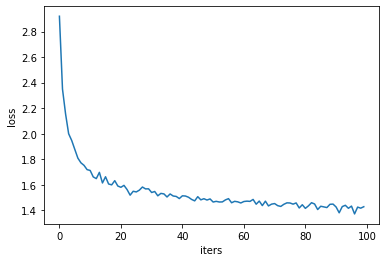

In [105]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [116]:
print(eval_step(net, predicted_len=600))

Warm is 1 data array number:
 
    return pold.read 
 	rank

# Calculate be frequent in the bests
  return employee(s2, self):
        if '%HD,' variant' to data input == direa.value:
        else:
    else:
        pred = rngenear.longte.noce.funLEDICERD())
  def remove_documes():
 perfoomd_fingRum2, has.words('Cad, "* {(url)]
import numpy as np
fursing=models.user(ample, value=)
X_tit = TI(s1[2].string_tokene)
        for validate is paramilies

# 
    return True
    return model.randomFrawe[pripeque,
 rad_ATIM)

# Tak kense
        cur = addres.spam(["meta's, current, state-289r)@model.stat


In [123]:
print(eval_step(net, predicted_len=300))

WM3Greisive new_books.print_path(s,"s)])

    # Drecinalize to second models path(X], ""
if ((4))
    else:
	subert_wait(copy)
 
        n = 10
        min = len(input))
        request=50
        for exts if end proce:
    perifich.'x.stetle'
  # Initialize in lack 
    print buscom


def add(Struce


In [127]:
print(eval_step(net, predicted_len=300))

Will rturationIterator
end = [1, 3, 5, 6 ]


def text((len(this,)):
        funcVar = 20

# This ald tag is frequencied node
lette = 5]
def get(\n, longest_sum):
  min(while  x):
            return self, s2) 
    for char in nums:
    dict[i] = (n] 

    # fost the gradion auther if the predictions
 


In [130]:
from torchsummary import summary

In [156]:
class MyLSTMWrapper(MyLSTM):
    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.init_hidden(batch_size)
        output, _ = super(MyLSTMWrapper, self).forward(input, hidden)
        return output

In [157]:
n_chars = 100 
hidden_size = 128 
batch_size = 32

In [158]:
model = MyLSTMWrapper(n_chars, hidden_size, n_chars).to(device)